# Personal Information
Name: **Réka Mária Szabó**

StudentID: **15087972**

Email: [**reka.szabo@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

GitHib repository link : **https://github.com/szabreka/uva_thesis_project**

*note: the repository of the project is private*

# Data Context
**RISE dataset** 
The open-source RISE (Recognizing Industrial Smoke Emission) dataset introduced by Hsu et al. (2021) is the first large-scale video dataset for industrial smoke emission recognition, containing 12,567 labeled clips with binary classes. The dataset contains a wide variety of clips, including industrial smoke under a range of weather conditions, in many forms, and also in the presence of steam. The dataset can be approached on the following link: https://github.com/CMU-CREATE-Lab/deep-smoke-machine/tree/master/back-end/data/dataset/2020-02-24. For this project, the dataset version from 2020 will be utilized, as this version contains only labeled data. For EDA purposes, the metadata_02242020.json file will be analyzed.

Origin paper: 
Yen-Chia Hsu, Ting-Hao (Kenneth) Huang, Ting-Yao Hu, Paul Dille, Sean Prendi, Ryan Hoffman, Anastasia Tsuhlares, Jessica Pachuta, Randy Sargent, and Illah Nourbakhsh. 2021. Project RISE: Recognizing Industrial Smoke Emissions. Proceedings of the AAAI Conference on Artificial Intelligence (AAAI 2021). https://ojs.aaai.org/index.php/AAAI/article/view/17739

**IJmond video dataset** 
Similarly to the RISE dataset, the IJmond video set contains labeled videos from the IJmondCAM web tool, operated by the Frisse Wind community and Greenpeace Netherlands. The dataset is a snapshot of the original database's state on January 22, 2024. The dataset includes only 879 clips of an industrial facility but can be significant in identifying local pollution patterns. The dataset is available on the following link: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/main/dataset/2024-01-22#ijmond-video-dataset-2024-01-22. For EDA purposes, the metadata_ijmond_jan_22_2024.json file will be analyzed.

# Data Description

In my thesis work, I will work with the two mentioned datasets. Each dataset contains video clips of industrial facilities and labels stating whether the video clip contains smoke. The aim of the project is to design and implement a lightweight CLIP-based ensemble model for state-of-the-art industrial smoke detection. Thus, the target variable is a categorical variable with two possible values: 'smoke' or 'no smoke'. The model will predict based on the spatiotemporal features of the videos, using both a lightweight CNN and a CLIP model.

The IJmond metadata set includes 879 clips and contains no missing values. The clips are footage from 3 cameras from which several views have been cropped. The videos were recorded between 2022-05-04 and 2023-08-09. There are 3 videos that can't be used for training the model which can be dropped from the dataset during the preprocessing phase. After dropping these columns, 55% of the videos had smoke on them, suggesting a mild class imbalance. Based on this ratio, 55% can be a good baseline for the proposed model during the project. The videos can be downloaded by using the variables in the metadataset (this method will be explained later). The videos can have different dimensions and are in RGB.

The RISE metadata set includes 12567 labeled clips and contains no missing values. The clips are footage from 3 cameras from which several views have been cropped. The videos were recorded between 2018-05-11 and 2019-08-11. All videos can be used for training purposes. In the RISE dataset, 40.5% of the videos contain smoke, suggesting class imbalance. Based on this ratio, 40.5% can be a good baseline for the proposed model during the project. The videos can be downloaded in 180x180 and 320x320 resolution by using the variables in the metadata set (this method will be explained later). The videos have the same dimensions and are in RGB.

The two datasets contain identical columns with the same name, datatype, and content. Therefore, these metadata sets can be concatenated together. By doing so, 41.45% of the videos contain smoke in the merged dataset.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import Video
import cv2

### Data Loading

In [2]:
#load IJMond dataset
ijmond_df = pd.read_json('../data/metadata_ijmond_jan_22_2024.json')

In [3]:
#load RISE dataset
rise_df = pd.read_json('../data/metadata_02242020.json')

### Analysis of IJmond dataset 

In [4]:
# Inspecting general data attributes
ijmond_df.head()

,camera_id,file_name,id,label_state,label_state_admin,start_time,url_part,url_root,view_id
0,1,A9W8G55JucU-3,75,23,23,2023-03-24 17:47:46,A9W8G55JucU,https://ijmondcam.multix.io/videos/,3
1,1,23x-vGYMbec-2,6,16,32,2023-04-12 08:42:50,23x-vGYMbec,https://ijmondcam.multix.io/videos/,2
2,0,mRjzTfzMS1I-4,843,16,16,2023-07-18 16:56:58,mRjzTfzMS1I,https://ijmondcam.multix.io/videos/,4
3,0,aFhpESIPnXg-4,787,16,16,2023-06-17 08:53:21,aFhpESIPnXg,https://ijmondcam.multix.io/videos/,4
4,1,Qv9-nS5BloI-2,81,23,47,2023-06-07 12:13:22,Qv9-nS5BloI,https://ijmondcam.multix.io/videos/,2


In [5]:
#IJmond dataset variables
ijmond_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   camera_id          879 non-null    int64         
 1   file_name          879 non-null    object        
 2   id                 879 non-null    int64         
 3   label_state        879 non-null    int64         
 4   label_state_admin  879 non-null    int64         
 5   start_time         879 non-null    datetime64[ns]
 6   url_part           879 non-null    object        
 7   url_root           879 non-null    object        
 8   view_id            879 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 61.9+ KB


The dataset contains 879 records, with no missing or null values, and has 9 variables with the datatypes of int64(5), object(3), and datetime64[ns] (1).

In [6]:
#Function to get video URL-s
#The code below is copied from the following repository: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/92e1b446c4c0fb5f36cfe487e645e5065c9800aa/dataset/2024-01-22#ijmond-video-dataset-2024-01-22 repository README file to achive the URLs of the IJMond dataset
def get_video_url(v):
    """
    Get the video URL.

    Parameters
    ----------
    v : dict
        The dictionary with keys and values in the video dataset JSON file.

    Returns
    -------
    str
        The full URL of the video.
    """
    camera_names = ["hoogovens", "kooksfabriek_1", "kooksfabriek_2"]
    return v["url_root"] + camera_names[v["camera_id"]] + "/" +  v["url_part"] + "/" + v["file_name"] + ".mp4"

In [7]:
#Function to get video panorama URL-s
#The code below is copied from the following repository: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/92e1b446c4c0fb5f36cfe487e645e5065c9800aa/dataset/2024-01-22#ijmond-video-dataset-2024-01-22 repository README file to achive the URLs of the IJMond dataset
def get_video_panorama_url(v):
    """
    Get the video panorama URL.

    Parameters
    ----------
    v : dict
        The dictionary with keys and values in the video dataset JSON file.

    Returns
    -------
    str
        The full URL of the panorama video.
    """
    return "https://www.youtube.com/watch?v=" + v["url_part"]

In [8]:
#This code is imported from the following repository: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/92e1b446c4c0fb5f36cfe487e645e5065c9800aa/dataset/2024-01-22#ijmond-video-dataset-2024-01-22 repository README file. It is modified to get the URL of the cropped and original panorama video belonging to the first 3 records. The get_video_url() and get_video_panorama_url() functions are invited from an eda_functions.py script.

# Specify the path to the JSON file
json_file_path = "../data/metadata_ijmond_jan_22_2024.json"

# Open the file and load its contents into a dictionary
with open(json_file_path, "r") as json_file:
    data_dict = json.load(json_file)

# Print the video URLs of the first 5 record
for v in data_dict[:3]:
  print("Video id:", v['id'])
  print("Video URL:")
  print(get_video_url(v))
  print("Video Panorama URL:")
  print(get_video_panorama_url(v))
  print()

Video id: 75
Video URL:
https://ijmondcam.multix.io/videos/kooksfabriek_1/A9W8G55JucU/A9W8G55JucU-3.mp4
Video Panorama URL:
https://www.youtube.com/watch?v=A9W8G55JucU

Video id: 6
Video URL:
https://ijmondcam.multix.io/videos/kooksfabriek_1/23x-vGYMbec/23x-vGYMbec-2.mp4
Video Panorama URL:
https://www.youtube.com/watch?v=23x-vGYMbec

Video id: 843
Video URL:
https://ijmondcam.multix.io/videos/hoogovens/mRjzTfzMS1I/mRjzTfzMS1I-4.mp4
Video Panorama URL:
https://www.youtube.com/watch?v=mRjzTfzMS1I



The **cropped video clip URL** can be produced by combining the `url_root`, the camera names from `camera_id`, the `url:part`, and the `file_name` with the following method: **v["url_root"] + camera_names[v["camera_id"]] + "/" +  v["url_part"] + "/" + v["file_name"] + ".mp4"**. The industrial smoke clips are available on the produced URLs on the https://ijmondcam.multix.io website. In the `camera_id` variable, the value 0 marks hoogovens, 1 marks kooksfabriek_1, and 2 marks kooksfabriek_2, 

The **original video URL**, which is where the clip has been cropped from, is available on YouTube and can be accessed by combining "https://www.youtube.com/watch?v=" and the `url_part` variable. The video that can be seen on the produced URL is a panorama recorded by one of the 3 cameras. From these panoramas, several crops were produced and named as a view in the dataset. Each view has an ID available in the `view_id` variable.

In [9]:
#inspecting how many views have been created from each camera footage
for i in range(3):
  view = ijmond_df[ijmond_df['camera_id'] == i]['view_id'].unique()
  print("camera_id", i, "view_id", view)

camera_id 0 view_id [4 3 0 1 2]
camera_id 1 view_id [3 2 0 1]
camera_id 2 view_id [0 1]


In [10]:
print("First clip in dataset:", min(ijmond_df.start_time))
print("Last clip in dataset:", max(ijmond_df.start_time))

First clip in dataset: 2022-05-04 11:05:23
Last clip in dataset: 2023-08-09 19:36:53


In [11]:
# Get the counts of each label state, given by a researcher (admin) or citizen(s)
count_by_admin_label = ijmond_df['label_state_admin'].value_counts()
count_by_label = ijmond_df['label_state'].value_counts()
print('count by admin label:')
print(count_by_admin_label)
print()  
print('count_by_label:')
print(count_by_label)

count by admin label:
 23    433
 16    322
 32     49
 47     48
-1      26
-2       1
Name: label_state_admin, dtype: int64

count_by_label:
 16    382
 23    308
-1      80
 20     55
 19     49
 3       3
 4       1
 5       1
Name: label_state, dtype: int64


In the dataset, positive = has smoke, negative = no smoke

**For admin labels (label_state_admin):**
- -2 : bad video
- -1: means that the labels were assigned in individual mode by citizens 
- 23: researcher labeled the video positive 
- 16: researcher labeled the video negative
- 32 : gold standard negative
- 47 : gold standard positive


**For citizen labels (label_state):**
- 23: two citizen labeled the video positive 
- 16: two citizen labeled the video negative 
- 20: two volunteers have different answers, and the third volunteer says that the video does not have smoke (weak negative) 
- 19: two volunteers have different answers, and the third volunteer says that the video has smoke (weak positive) 
- 5: one volunteers says that the video has smoke (maybe positive) 
- 4: one volunteers says that the video does not have smoke (maybe negative) 
- 3: two volunteers have different answers (one says yes, and another one says no)
- -1: the labels were assigned by researchers in individual mode 

In [12]:
#Function to get labeling mode
def get_mode(row):
    if row['label_state'] == -1:
        return 'individual mode R'
    elif row['label_state_admin'] == -1:
        return 'individual mode C'
    elif row['label_state_admin'] == -2:
        return 'bad videos'
    else:
        return 'collaborative mode'

In [13]:
#Inspecting the mode of labeling by using the get_mode() function. 
#This function examines if the label was given in individual mode by a researcher (individual mode R) or a citizen (individual mode C), in collaborative mode (collaborative mode) where the citizens and the researchers collaborated on the labeling task, or if the video was labeled as a bad video.
ijmond_df['mode'] = ijmond_df.apply(get_mode, axis=1)
ijmond_df['mode'].value_counts()

collaborative mode    774
individual mode R      80
individual mode C      24
bad videos              1
Name: mode, dtype: int64

In the IJMond dataset, 774 videos were labeled in collaborative mode, 80 videos were labeled by the researchers only in individual mode, 24 videos were labeled by only citizens in individual mode, and 1 video was labeled as a bad video by researchers. This video can be deleted from the dataset, as its quality is not good enough.

In [14]:
#Function to get the categorical label for the videos, based on the 'mode', 'label_state', and 'label_state_admin' variables
def get_label(row):
    if row['mode'] == 'individual mode R':
        if row['label_state_admin'] == 23:
            return 'smoke'
        if row['label_state_admin'] == 16:
            return 'no smoke'
        if row['label_state_admin'] == 47:
            return 'smoke'
        if row['label_state_admin'] == 32:
            return 'no smoke'

    if row['mode'] == 'individual mode C':
        if row['label_state'] == 23:
            return 'smoke'
        if row['label_state'] == 16:
            return 'no smoke'
        if row['label_state'] == 19:
            return 'smoke'
        if row['label_state'] == 20:
            return 'no smoke'
    if row['mode'] == 'collaborative mode':
        if row['label_state_admin'] == 23:
            return 'smoke'
        if row['label_state_admin'] == 16:
            return 'no smoke'
        if row['label_state_admin'] == 47:
            return 'smoke'
        if row['label_state_admin'] == 32:
            return 'no smoke'
        else:
            if row['label_state'] == 23:
                return 'smoke'
            if row['label_state'] == 16:
                return 'no smoke'
    else:
        if row['label_state_admin'] == -2:
            return 'bad videos'
        else:
            return 'video not labeled'

In [15]:
#Creating a variable to determine if the video contains smoke or not, by using the get_label function
ijmond_df['label'] = ijmond_df.apply(get_label, axis=1)
ijmond_df['label'].value_counts()

smoke                482
no smoke             394
video not labeled      2
bad videos             1
Name: label, dtype: int64

In the IJMond dataset, there are 482 videos with smoke and 394 videos with no smoke. There are also two videos that not have been labeled, therefore these records can be deleted, alongside the bad video.

In [16]:
ijmond_df = ijmond_df.drop(ijmond_df[ijmond_df['label'] == 'video not labeled'].index)
ijmond_df = ijmond_df.drop(ijmond_df[ijmond_df['label'] == 'bad videos'].index)
ijmond_df['label'].value_counts()

smoke       482
no smoke    394
Name: label, dtype: int64

In [17]:
#Count remaining videos
count_videos = len(ijmond_df)
print(count_videos)

876


In [18]:
smoke_videos = len(ijmond_df[ijmond_df['label'] == 'smoke'])
smoke_video_ratio = round(smoke_videos/count_videos * 100, 2)
print(f"{smoke_video_ratio}% of the videos contain smoke in the IJmond dataset after dropping useless clips from the dataset.")

55.02% of the videos contain smoke in the IJmond dataset after dropping useless clips from the dataset.


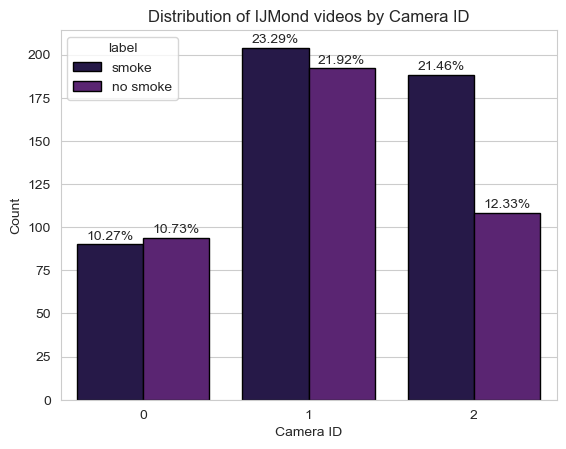

In [19]:
# Create the barchart for the label distribution of the cameras
sns.set_style("whitegrid")
magma_palette = sns.color_palette("magma")
ax = sns.countplot(data=ijmond_df, x='camera_id', hue='label', edgecolor='black', palette=magma_palette)
total_count = len(ijmond_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 3, '{:.2f}%'.format((height / total_count) * 100), ha="center")
plt.xlabel("Camera ID")
plt.ylabel("Count")
plt.title('Distribution of IJMond videos by Camera ID')
plt.show()

In [20]:
pd.crosstab(index=[ijmond_df['camera_id'], ijmond_df['view_id']], columns=ijmond_df['label'])

label              no smoke  smoke
camera_id view_id                 
0         0              33      4
          1              27      9
          2               9     28
          3              10     27
          4              15     22
1         0              65     34
          1              52     47
          2              49     50
          3              26     73
2         0              60     87
          1              48    101

In [21]:
#Function to get the season of videos
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

In [22]:
#Adding time attributes for EDA
ijmond_df_time =  ijmond_df
ijmond_df_time['start_time'] = pd.to_datetime(ijmond_df_time['start_time'])
ijmond_df_time['month'] = ijmond_df_time['start_time'].dt.month
ijmond_df_time['hour'] = ijmond_df_time['start_time'].dt.hour
ijmond_df_time['day'] =  ijmond_df_time['start_time'].dt.weekday
ijmond_df_time['season'] = ijmond_df_time['month'].apply(get_season)
ijmond_df_time.head()

,camera_id,file_name,id,label_state,label_state_admin,start_time,url_part,url_root,view_id,mode,label,month,hour,day,season
0,1,A9W8G55JucU-3,75,23,23,2023-03-24 17:47:46,A9W8G55JucU,https://ijmondcam.multix.io/videos/,3,collaborative mode,smoke,3,17,4,spring
1,1,23x-vGYMbec-2,6,16,32,2023-04-12 08:42:50,23x-vGYMbec,https://ijmondcam.multix.io/videos/,2,collaborative mode,no smoke,4,8,2,spring
2,0,mRjzTfzMS1I-4,843,16,16,2023-07-18 16:56:58,mRjzTfzMS1I,https://ijmondcam.multix.io/videos/,4,collaborative mode,no smoke,7,16,1,summer
3,0,aFhpESIPnXg-4,787,16,16,2023-06-17 08:53:21,aFhpESIPnXg,https://ijmondcam.multix.io/videos/,4,collaborative mode,no smoke,6,8,5,summer
4,1,Qv9-nS5BloI-2,81,23,47,2023-06-07 12:13:22,Qv9-nS5BloI,https://ijmondcam.multix.io/videos/,2,collaborative mode,smoke,6,12,2,summer


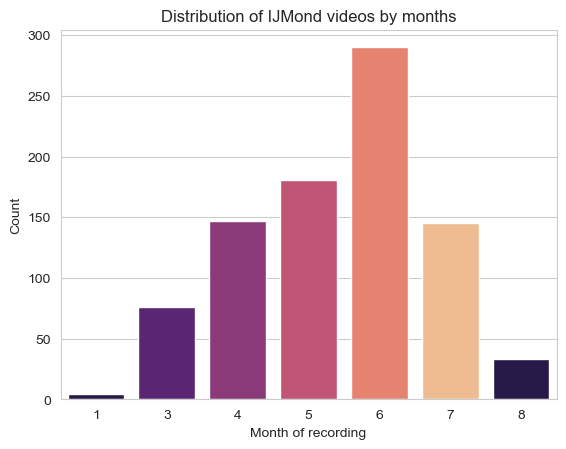

In [23]:
ax = sns.countplot(data=ijmond_df_time, x='month', palette=magma_palette)   
plt.xlabel("Month of recording")
plt.ylabel("Count")
plt.title('Distribution of IJMond videos by months')
plt.show()

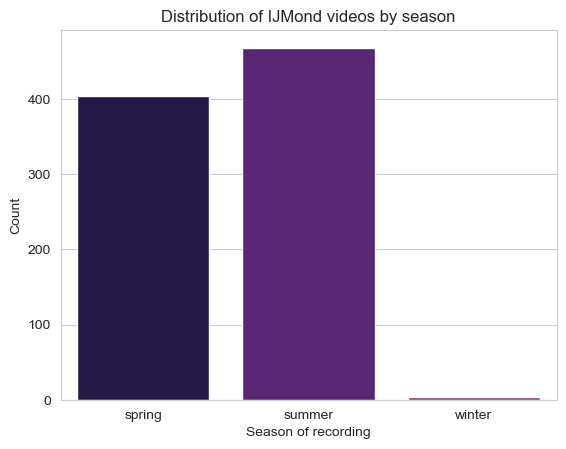

In [24]:
ax = sns.countplot(data=ijmond_df_time, x='season', palette=magma_palette)   
plt.xlabel("Season of recording")
plt.ylabel("Count")
plt.title('Distribution of IJMond videos by season')
plt.show()

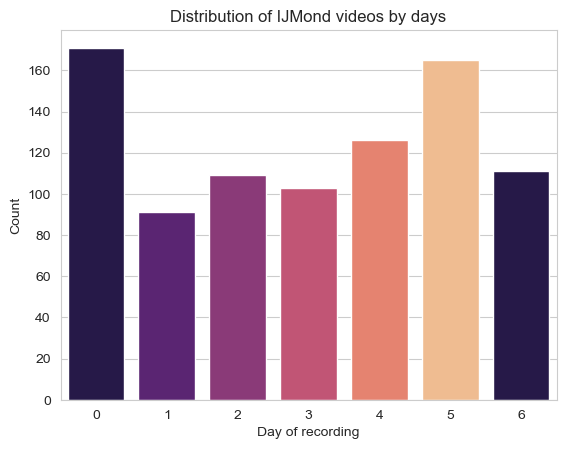

In [25]:
#Where 0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday, 4: Friday, 5: Saturday, 6: Sunday
ax = sns.countplot(data=ijmond_df_time, x='day', palette=magma_palette)   
plt.xlabel("Day of recording")
plt.ylabel("Count")
plt.title('Distribution of IJMond videos by days')
plt.show()

In [26]:
#function to get the timeslot 
def get_timeslot(hour):
    if 6 <= hour <= 10:
        return '"6-10"'
    elif 11 <= hour <= 15:
        return '"11-15"'
    elif 16 <= hour <= 20:
        return '"16-20"'
    else:
        return '"21-5"'

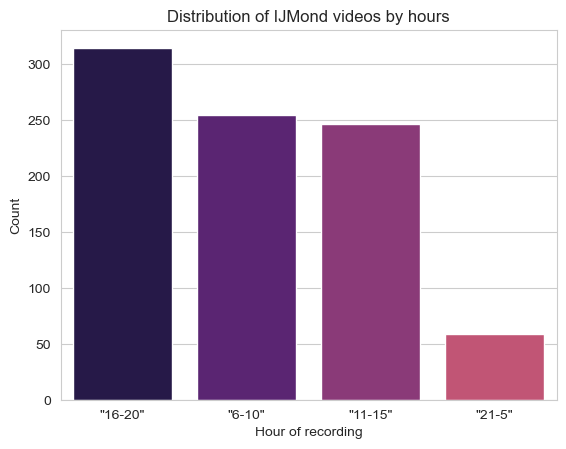

In [27]:
ijmond_df_time['hour'] = ijmond_df_time['hour'].apply(get_timeslot)
ax = sns.countplot(data=ijmond_df_time, x='hour', palette=magma_palette)   
plt.xlabel("Hour of recording")
plt.ylabel("Count")
plt.title('Distribution of IJMond videos by hours')
plt.show()

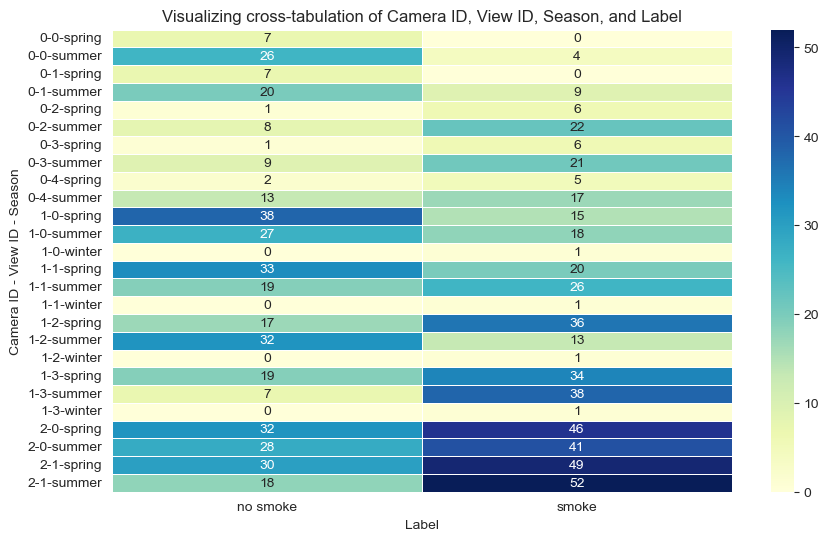

In [28]:
season_set = pd.crosstab(index=[ijmond_df_time['camera_id'], ijmond_df_time['view_id'], ijmond_df_time['season']], columns=ijmond_df_time['label'])

plt.figure(figsize=(10, 6))
sns.heatmap(season_set, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title('Visualizing cross-tabulation of Camera ID, View ID, Season, and Label')
plt.xlabel('Label')
plt.ylabel('Camera ID - View ID - Season')
plt.show()

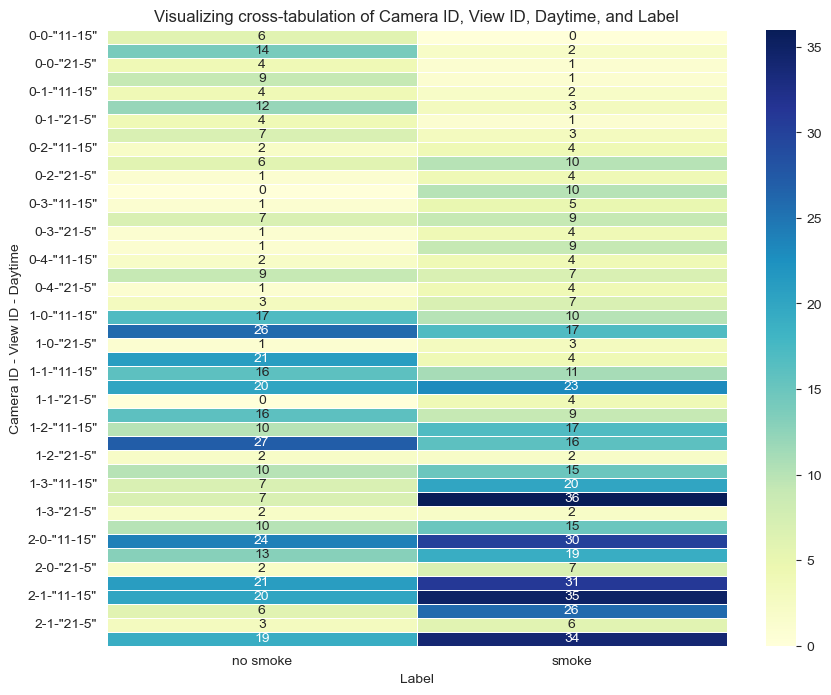

In [29]:
daytime_set = pd.crosstab(index=[ijmond_df_time['camera_id'], ijmond_df_time['view_id'], ijmond_df_time['hour']], columns=ijmond_df_time['label'])

plt.figure(figsize=(10, 8))
sns.heatmap(daytime_set, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title('Visualizing cross-tabulation of Camera ID, View ID, Daytime, and Label')
plt.xlabel('Label')
plt.ylabel('Camera ID - View ID - Daytime')
plt.show()

There can be seen class imbalance when compairing camera views at different seasons or daytimes.

In [31]:
#run python download_videos.py in terminal - this script was provided in the repository of the dataset: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/92e1b446c4c0fb5f36cfe487e645e5065c9800aa/dataset/2024-01-22#ijmond-video-dataset-2024-01-22
#display example video
video_path = '/Users/szaboreka/Documents/UvA/Thesis/uva_thesis_project/data/ijmond_videos/1LeRIZ-oQwo-0.mp4'
Video(video_path)

In [32]:
ijmond_df[ijmond_df["file_name"]=="_1jFnujWn50-1"]

,camera_id,file_name,id,label_state,label_state_admin,start_time,url_part,url_root,view_id,mode,label,month,hour,day,season
603,2,_1jFnujWn50-1,655,23,23,2023-06-17 04:17:42,_1jFnujWn50,https://ijmondcam.multix.io/videos/,1,collaborative mode,smoke,6,"""21-5""",5,summer


As can be seen, the example video contains smoke and was labeled in collaborative mode.

In [33]:
#Examining size of the opened example video:

video_size = os.path.getsize(video_path)
print("Size in bytes:",video_size)
# Convert to megabytes
video_size_mb = video_size / (1024 * 1024)
print("Size in megabytes:",video_size_mb)


#Examining another example:

other_video_path = '/Users/szaboreka/Documents/UvA/Thesis/uva_thesis_project/data/ijmond_videos/zcp85lNvskI-1.mp4'
other_video_size = os.path.getsize(other_video_path)
# Convert to megabytes
other_video_size_mb = other_video_size / (1024 * 1024)
print("Another examople video size in megabytes:",other_video_size_mb)

Size in bytes: 899494
Size in megabytes: 0.8578243255615234
Another examople video size in megabytes: 0.4272041320800781


In [34]:
vid1 = cv2.VideoCapture(video_path)

# Get the dimensions of the first example video
print("\nExample video:")
ret, frame = vid1.read()
shape = frame.shape
fps = int(vid1.get(cv2.CAP_PROP_FPS))
total_frames = int(vid1.get(cv2.CAP_PROP_FRAME_COUNT))
video_length_seconds = total_frames / fps
print(f"Shape: {shape}")
print(f"Frame rate: {fps} frames per second")
print(f"Total number of frames: {total_frames}")
print(f"Total length in second: {video_length_seconds}")

print("\nOther example video:")
vid2 = cv2.VideoCapture(other_video_path)

# Get the dimensions of the second example video

ret, frame = vid2.read()
shape = frame.shape
fps = int(vid2.get(cv2.CAP_PROP_FPS))
total_frames = int(vid2.get(cv2.CAP_PROP_FRAME_COUNT))
video_length_seconds = total_frames / fps
print(f"Shape: {shape}")
print(f"Frame rate: {fps} frames per second")
print(f"Total number of frames: {total_frames}")
print(f"Total length in second: {video_length_seconds}")


Example video:
Shape: (900, 900, 3)
Frame rate: 26 frames per second
Total number of frames: 36
Total length in second: 1.3846153846153846

Other example video:
Shape: (600, 600, 3)
Frame rate: 25 frames per second
Total number of frames: 36
Total length in second: 1.44


The videos can have different file sizes and different dimensions. However, each video has 36 frames and is in RGB. Therefore, the video dimensions need to be handled during the preprocessing phase.

### Analysis of the RISE dataset: 

In [35]:
# Inspecting general data attributes
rise_df.head()

,camera_id,file_name,id,label_state,label_state_admin,start_time,url_part,url_root,view_id
0,0,0-7-2019-06-24-3504-1067-4125-1688-180-180-972...,103169,23,-1,2019-06-24 21:10:15,2019-06-24/0-7/0-7-2019-06-24-3504-1067-4125-1...,https://smoke.createlab.org/videos/180/,7
1,0,0-7-2019-02-03-3544-899-4026-1381-180-180-7424...,22392,23,-1,2019-02-03 18:09:35,2019-02-03/0-7/0-7-2019-02-03-3544-899-4026-13...,https://smoke.createlab.org/videos/180/,7
2,0,0-2-2018-07-07-5648-1004-6150-1506-180-180-598...,35476,23,-1,2018-07-07 15:20:35,2018-07-07/0-2/0-2-2018-07-07-5648-1004-6150-1...,https://smoke.createlab.org/videos/180/,2
3,0,0-6-2018-07-07-3981-1084-4484-1587-180-180-385...,36353,23,-1,2018-07-07 12:15:00,2018-07-07/0-6/0-6-2018-07-07-3981-1084-4484-1...,https://smoke.createlab.org/videos/180/,6
4,0,0-2-2018-09-19-5648-1004-6150-1506-180-180-100...,42767,23,-1,2018-09-19 21:43:05,2018-09-19/0-2/0-2-2018-09-19-5648-1004-6150-1...,https://smoke.createlab.org/videos/180/,2


In [36]:
#IJmond dataset variables
rise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12567 entries, 0 to 12566
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   camera_id          12567 non-null  int64         
 1   file_name          12567 non-null  object        
 2   id                 12567 non-null  int64         
 3   label_state        12567 non-null  int64         
 4   label_state_admin  12567 non-null  int64         
 5   start_time         12567 non-null  datetime64[ns]
 6   url_part           12567 non-null  object        
 7   url_root           12567 non-null  object        
 8   view_id            12567 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 883.7+ KB


The dataset contains 12567 records, with no missing or null values, and has 9 variables with the datatypes of int64(5), object(3), and datetime64[ns] (1), just like this IJMond dataset.

In [37]:
#inspecting how many views have been created from each camera footage
for i in range(len(rise_df.camera_id.unique())):
   view = rise_df[rise_df['camera_id'] == i]['view_id'].unique()
   print("camera_id", i, "view_id", view)

camera_id 0 view_id [ 7  2  6  4  9  0  8 10  1  5  3 13 14 11 12]
camera_id 1 view_id [0]
camera_id 2 view_id [1 0 2]


Similarly to the IJMond dataset, the RISE dataset also contains 3 different camera_id-s, marked with 0 (clairton1), 1 (braddock1), and 2 (westmifflin1). However, the RISE dataset contains 19 camera views, which are mostly cropped out from the clairton1 camera's panorama.


In [38]:
print("First clip:", min(rise_df.start_time))
print("Last clip:", max(rise_df.start_time))

First clip: 2018-05-11 10:21:10
Last clip: 2019-08-11 23:52:40


In [39]:
# Get the counts of each label state, given by a researcher (admin) or citizen(s)
count_by_admin_label = rise_df['label_state_admin'].value_counts()
count_by_label = rise_df['label_state'].value_counts()
print('count by admin label:')
print(count_by_admin_label)
print()  
print('count_by_label:')
print(count_by_label)

count by admin label:
 16    5642
 23    4365
-1     2560
Name: label_state_admin, dtype: int64

count_by_label:
-1     5230
 16    2572
 4     2288
 23    1295
 5      938
 20     100
 19      91
 3       53
Name: label_state, dtype: int64


In [40]:
#Get the labeling mode variable for the RISE dataset
rise_df['mode'] = rise_df.apply(get_mode, axis=1)
rise_df['mode'].value_counts()

individual mode R     5230
collaborative mode    4777
individual mode C     2560
Name: mode, dtype: int64

In the RISE dataset, 4777 videos were labeled in collaborative mode, 5230 videos were labeled by the researchers only in individual mode, and 2560 videos were labeled by only citizens in individual mode.

In [41]:
#Get the label variable for the RISE dataset
rise_df['label'] = rise_df.apply(get_label, axis=1)
rise_df['label'].value_counts()

no smoke    7477
smoke       5090
Name: label, dtype: int64

In the RISE dataset, there are 5090 videos with smoke and 7477 videos with no smoke. There are no unlabeled or bad videos.

In [42]:
#Function to get video URL-s
#The code below is copied from the following repository: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/92e1b446c4c0fb5f36cfe487e645e5065c9800aa/dataset/2024-01-22#ijmond-video-dataset-2024-01-22 repository README file to achive the URLs of the IJMond dataset
def get_video_url_180(v):
    """
    Get the video URL.

    Parameters
    ----------
    v : dict
        The dictionary with keys and values in the video dataset JSON file.

    Returns
    -------
    str
        The full URL of the video.
    """
    return v["url_root"] +  v["url_part"]

In [43]:
#Function to get video URL-s
#The code below is copied from the following repository: https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/92e1b446c4c0fb5f36cfe487e645e5065c9800aa/dataset/2024-01-22#ijmond-video-dataset-2024-01-22 repository README file to achive the URLs of the IJMond dataset
def get_video_url_320(v):
    """
    Get the video URL.

    Parameters
    ----------
    v : dict
        The dictionary with keys and values in the video dataset JSON file.

    Returns
    -------
    str
        The full URL of the video.
    """
    url_root_320 = v["url_root"].replace("180", "320")
    url_part_320 = v["url_part"].replace("-180-180-", "-320-320-")
    return url_root_320 + url_part_320

In [44]:
# Specify the path to the JSON file
json_file_path = "../data/metadata_02242020.json"

# Open the file and load its contents into a dictionary
with open(json_file_path, "r") as json_file:
    data_dict = json.load(json_file)

# Print the video URLs of the first 5 record
for v in data_dict[:3]:
  print("Video id:", v['id'])
  print("Video URL in 180 by 180 resolutions:")
  print(get_video_url_180(v))
  print("Video URL in 320 by 320 resolutions:")
  print(get_video_url_320(v))
  print()

Video id: 103169
Video URL in 180 by 180 resolutions:
https://smoke.createlab.org/videos/180/2019-06-24/0-7/0-7-2019-06-24-3504-1067-4125-1688-180-180-9722-1561410615-1561410790.mp4
Video URL in 320 by 320 resolutions:
https://smoke.createlab.org/videos/320/2019-06-24/0-7/0-7-2019-06-24-3504-1067-4125-1688-320-320-9722-1561410615-1561410790.mp4

Video id: 22392
Video URL in 180 by 180 resolutions:
https://smoke.createlab.org/videos/180/2019-02-03/0-7/0-7-2019-02-03-3544-899-4026-1381-180-180-7424-1549217375-1549217550.mp4
Video URL in 320 by 320 resolutions:
https://smoke.createlab.org/videos/320/2019-02-03/0-7/0-7-2019-02-03-3544-899-4026-1381-320-320-7424-1549217375-1549217550.mp4

Video id: 35476
Video URL in 180 by 180 resolutions:
https://smoke.createlab.org/videos/180/2018-07-07/0-2/0-2-2018-07-07-5648-1004-6150-1506-180-180-5981-1530976835-1530977015.mp4
Video URL in 320 by 320 resolutions:
https://smoke.createlab.org/videos/320/2018-07-07/0-2/0-2-2018-07-07-5648-1004-6150-1506-

The video URL-s for the RISE dataset can be produced by combining the `url_root` and the `url_part`. These clips are available on the https://smoke.createlab.org website. The videos are in 180 by 180 resolutions by default but are available also in 320 by 320 resolutions. For EDA purposes, I only downloaded a few 180x180 videos by running the `download_videos_rise.py` script, which is a modification of the code available on the following link: https://github.com/CMU-CREATE-Lab/deep-smoke-machine/blob/master/back-end/www/download_videos.py.

In [45]:
#Calculate the ratio of positive videos
count_videos = len(rise_df)
smoke_videos = len(rise_df[rise_df['label'] == 'smoke'])
smoke_video_ratio = round(smoke_videos/count_videos * 100, 2)
print(f"{smoke_video_ratio}% of the videos contain smoke in the RISE dataset.")

40.5% of the videos contain smoke in the RISE dataset.


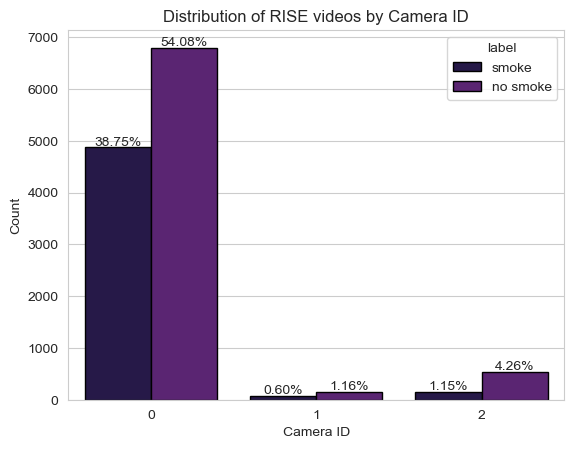

In [46]:
# Create the barchart for the label distribution of the cameras
sns.set_style("whitegrid")
magma_palette = sns.color_palette("magma")
ax = sns.countplot(data=rise_df, x='camera_id', hue='label', edgecolor='black', palette=magma_palette)
total_count = len(rise_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 40, '{:.2f}%'.format((height / total_count) * 100), ha="center")
plt.xlabel("Camera ID")
plt.ylabel("Count")
plt.title('Distribution of RISE videos by Camera ID')
plt.show()

In [47]:
pd.crosstab(index=[rise_df['camera_id'], rise_df['view_id']], columns=rise_df['label'])

label              no smoke  smoke
camera_id view_id                 
0         0             283    516
          1             244    509
          2             297    482
          3             359    399
          4             340    490
          5             532    227
          6             239    539
          7             304    416
          8             266    510
          9             304    404
          10            553    237
          11            725     46
          12            771     35
          13            770     38
          14            809     22
1         0             146     75
2         0             136     72
          1             195     38
          2             204     35

In [48]:
#Adding time attributes for EDA
rise_df_time =  rise_df
rise_df_time['start_time'] = pd.to_datetime(rise_df_time['start_time'])
rise_df_time['month'] = rise_df_time['start_time'].dt.month
rise_df_time['hour'] = rise_df_time['start_time'].dt.hour
rise_df_time['day'] =  rise_df_time['start_time'].dt.weekday
rise_df_time['season'] = rise_df_time['month'].apply(get_season)

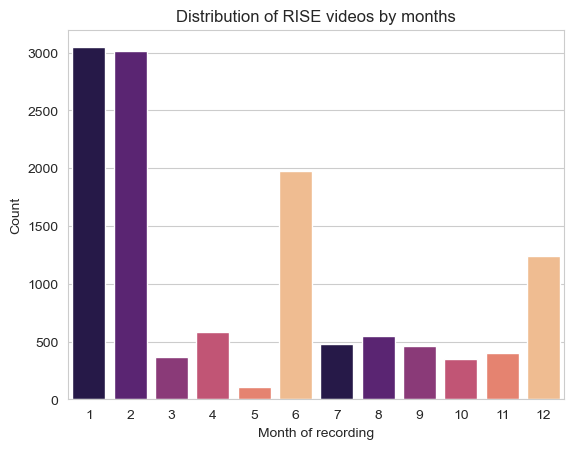

In [49]:
ax = sns.countplot(data=rise_df_time, x='month', palette=magma_palette)   
plt.xlabel("Month of recording")
plt.ylabel("Count")
plt.title('Distribution of RISE videos by months')
plt.show()

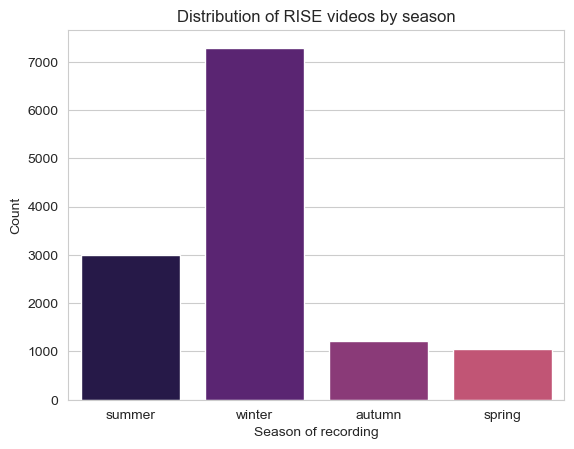

In [50]:
ax = sns.countplot(data=rise_df_time, x='season', palette=magma_palette)   
plt.xlabel("Season of recording")
plt.ylabel("Count")
plt.title('Distribution of RISE videos by season')
plt.show()

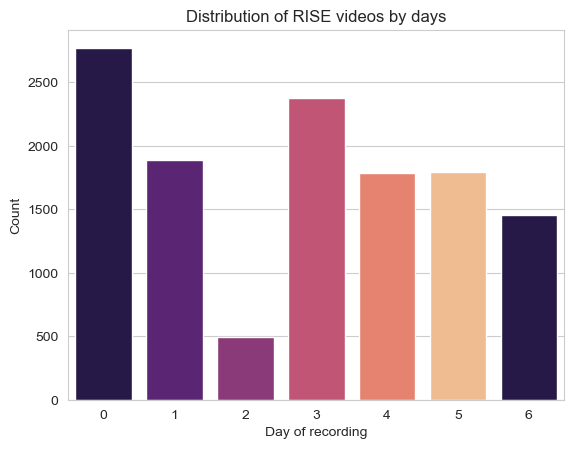

In [51]:
#Where 0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday, 4: Friday, 5: Saturday, 6: Sunday
ax = sns.countplot(data=rise_df_time, x='day', palette=magma_palette)   
plt.xlabel("Day of recording")
plt.ylabel("Count")
plt.title('Distribution of RISE videos by days')
plt.show()

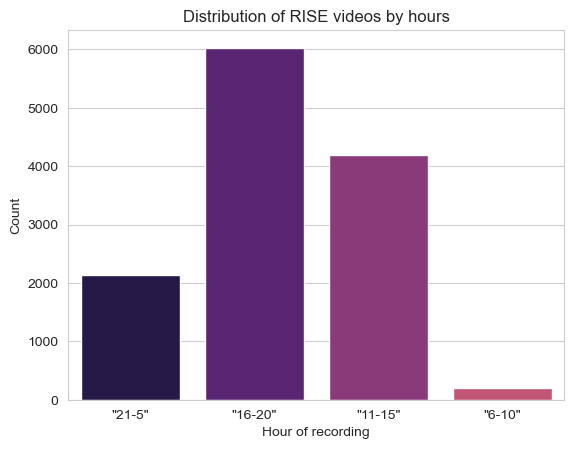

In [52]:
rise_df_time['hour'] = rise_df_time['hour'].apply(get_timeslot)
ax = sns.countplot(data=rise_df_time, x='hour', palette=magma_palette)   
plt.xlabel("Hour of recording")
plt.ylabel("Count")
plt.title('Distribution of RISE videos by hours')
plt.show()

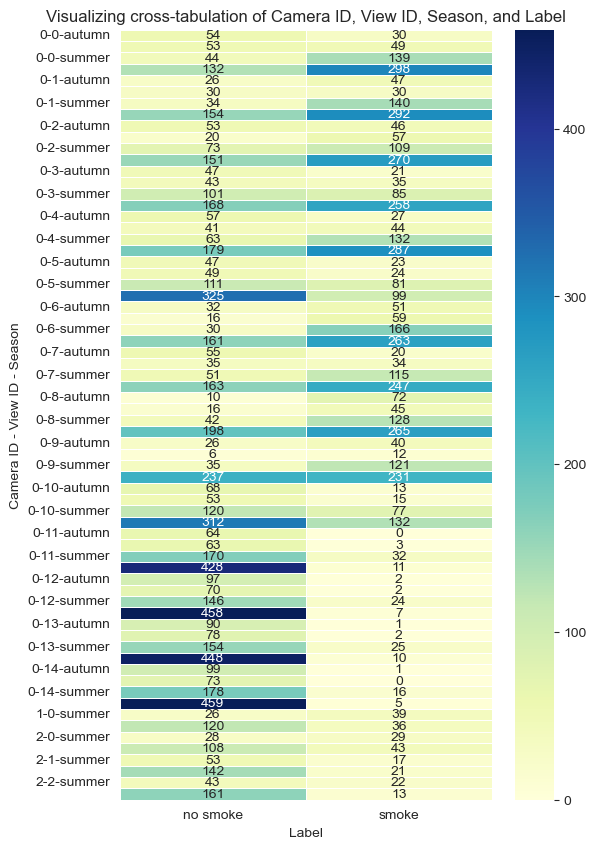

In [53]:
season_set = pd.crosstab(index=[rise_df_time['camera_id'], rise_df_time['view_id'], rise_df_time['season']], columns=rise_df_time['label'])

plt.figure(figsize=(6, 10))
sns.heatmap(season_set, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title('Visualizing cross-tabulation of Camera ID, View ID, Season, and Label')
plt.xlabel('Label')
plt.ylabel('Camera ID - View ID - Season')
plt.show()

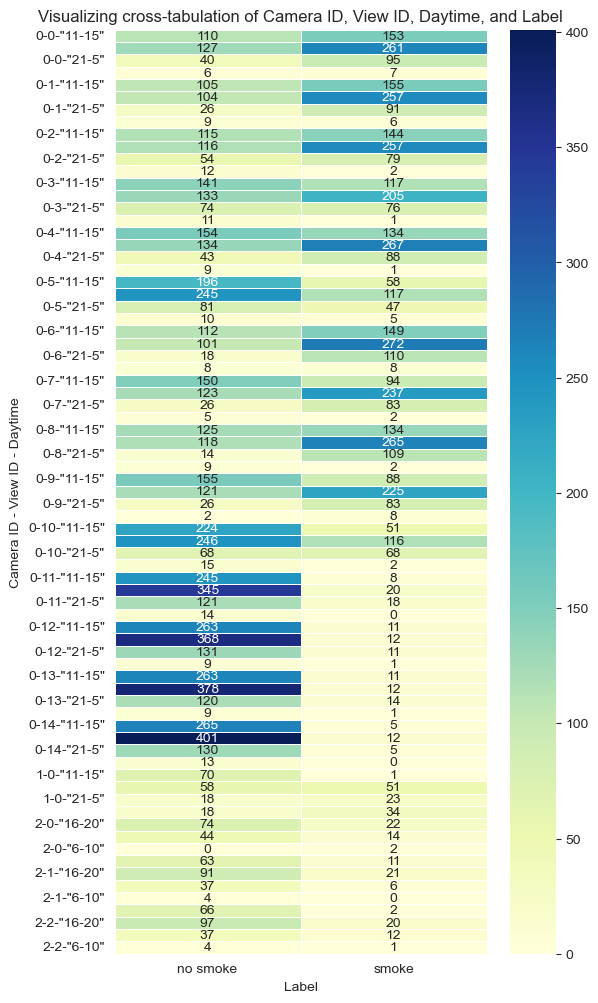

In [54]:
daytime_set = pd.crosstab(index=[rise_df_time['camera_id'], rise_df_time['view_id'], rise_df_time['hour']], columns=rise_df_time['label'])

plt.figure(figsize=(6, 12))
sns.heatmap(daytime_set, cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title('Visualizing cross-tabulation of Camera ID, View ID, Daytime, and Label')
plt.xlabel('Label')
plt.ylabel('Camera ID - View ID - Daytime')
plt.show()

There can be seen class imbalance when compairing camera views at different seasons or daytimes.

In [55]:
#display example video
video_path = '/Users/szaboreka/Documents/UvA/Thesis/uva_thesis_project/data/rise_videos/0-0-2018-06-11-6304-964-6807-1467-180-180-13946-1528764620-1528764795.mp4'
Video(video_path)

In [56]:
rise_df[rise_df["file_name"]=="0-0-2018-06-11-6304-964-6807-1467-180-180-13946-1528764620-1528764795"]

,camera_id,file_name,id,label_state,label_state_admin,start_time,url_part,url_root,view_id,mode,label,month,hour,day,season
21,0,0-0-2018-06-11-6304-964-6807-1467-180-180-1394...,297,23,-1,2018-06-12 00:50:20,2018-06-11/0-0/0-0-2018-06-11-6304-964-6807-14...,https://smoke.createlab.org/videos/180/,0,individual mode C,smoke,6,"""21-5""",1,summer


As can be seen, the example video contains smoke and was labeled by citizens in individual mode.

In [57]:
#Examining size of the opened example video:

video_size = os.path.getsize(video_path)
print("Size in bytes:",video_size)
# Convert to megabytes
video_size_mb = video_size / (1024 * 1024)
print("Size in megabytes:",video_size_mb)


#Examining another example:

other_video_path = '/Users/szaboreka/Documents/UvA/Thesis/uva_thesis_project/data/rise_videos/0-1-2018-08-06-6007-1008-6509-1510-180-180-9835-1533587420-1533587730.mp4'
other_video_size = os.path.getsize(other_video_path)
# Convert to megabytes
other_video_size_mb = other_video_size / (1024 * 1024)
print("Another example video size in megabytes:",other_video_size_mb)

Size in bytes: 54656
Size in megabytes: 0.0521240234375
Another example video size in megabytes: 0.06743431091308594


In [58]:
vid1 = cv2.VideoCapture(video_path)

# Get the dimensions of the first example video
print("\nExample video:")
ret, frame = vid1.read()
shape = frame.shape
fps = int(vid1.get(cv2.CAP_PROP_FPS))
total_frames = int(vid1.get(cv2.CAP_PROP_FRAME_COUNT))
video_length_seconds = total_frames / fps
print(f"Shape: {shape}")
print(f"Frame rate: {fps} frames per second")
print(f"Total number of frames: {total_frames}")
print(f"Total length in second: {video_length_seconds}")

print("\nOther example video:")
vid2 = cv2.VideoCapture(other_video_path)

# Get the dimensions of the second example video

ret, frame = vid2.read()
shape = frame.shape
fps = int(vid2.get(cv2.CAP_PROP_FPS))
total_frames = int(vid2.get(cv2.CAP_PROP_FRAME_COUNT))
video_length_seconds = total_frames / fps
print(f"Shape: {shape}")
print(f"Frame rate: {fps} frames per second")
print(f"Total number of frames: {total_frames}")
print(f"Total length in second: {video_length_seconds}")


Example video:
Shape: (180, 180, 3)
Frame rate: 12 frames per second
Total number of frames: 36
Total length in second: 3.0

Other example video:
Shape: (180, 180, 3)
Frame rate: 12 frames per second
Total number of frames: 36
Total length in second: 3.0


The videos can have different file sizes. However, each video has 36 frames, in RGB and has the same dimensions. Therefore, the video dimensions do not need to be handled during the preprocessing phase.

### Analysis of merged dataset:
The two datasets contain identical columns with the same name, datatype and content. Therefore, these metadata datasets can be concatenated together for further analysis.

In [59]:
#adding dataset variable marking the origin dataset
rise_df['dataset'] = 'rise'
ijmond_df['dataset'] = 'ijmond'
merged_dataset = pd.concat([rise_df, ijmond_df], ignore_index=True)
merged_dataset

,camera_id,file_name,id,label_state,label_state_admin,start_time,url_part,url_root,view_id,mode,label,month,hour,day,season,dataset
0,0,0-7-2019-06-24-3504-1067-4125-1688-180-180-972...,103169,23,-1,2019-06-24 21:10:15,2019-06-24/0-7/0-7-2019-06-24-3504-1067-4125-1...,https://smoke.createlab.org/videos/180/,7,individual mode C,smoke,6,"""21-5""",0,summer,rise
1,0,0-7-2019-02-03-3544-899-4026-1381-180-180-7424...,22392,23,-1,2019-02-03 18:09:35,2019-02-03/0-7/0-7-2019-02-03-3544-899-4026-13...,https://smoke.createlab.org/videos/180/,7,individual mode C,smoke,2,"""16-20""",6,winter,rise
2,0,0-2-2018-07-07-5648-1004-6150-1506-180-180-598...,35476,23,-1,2018-07-07 15:20:35,2018-07-07/0-2/0-2-2018-07-07-5648-1004-6150-1...,https://smoke.createlab.org/videos/180/,2,individual mode C,smoke,7,"""11-15""",5,summer,rise
3,0,0-6-2018-07-07-3981-1084-4484-1587-180-180-385...,36353,23,-1,2018-07-07 12:15:00,2018-07-07/0-6/0-6-2018-07-07-3981-1084-4484-1...,https://smoke.createlab.org/videos/180/,6,individual mode C,smoke,7,"""11-15""",5,summer,rise
4,0,0-2-2018-09-19-5648-1004-6150-1506-180-180-100...,42767,23,-1,2018-09-19 21:43:05,2018-09-19/0-2/0-2-2018-09-19-5648-1004-6150-1...,https://smoke.createlab.org/videos/180/,2,individual mode C,smoke,9,"""21-5""",2,autumn,rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13438,0,TUZbSqcLVtU-4,700,23,47,2023-06-09 18:51:13,TUZbSqcLVtU,https://ijmondcam.multix.io/videos/,4,collaborative mode,smoke,6,"""16-20""",4,summer,ijmond
13439,1,crAL3CrEt3s-0,172,16,16,2023-04-10 13:19:14,crAL3CrEt3s,https://ijmondcam.multix.io/videos/,0,collaborative mode,no smoke,4,"""11-15""",0,spring,ijmond
13440,1,DoNtmf5UBkY-1,381,-1,23,2023-07-08 15:49:13,DoNtmf5UBkY,https://ijmondcam.multix.io/videos/,1,individual mode R,smoke,7,"""11-15""",5,summer,ijmond
13441,2,ewJnawMTdAU-0,583,-1,16,2023-03-26 16:25:53,ewJnawMTdAU,https://ijmondcam.multix.io/videos/,0,individual mode R,no smoke,3,"""16-20""",6,spring,ijmond


In [60]:
#Calculate the ratio of positive videos
count_videos = len(merged_dataset)
smoke_videos = len(merged_dataset[merged_dataset['label'] == 'smoke'])
smoke_video_ratio = round(smoke_videos/count_videos * 100, 2)
print(f"{smoke_video_ratio}% of the videos contain smoke in the merged dataset.")

41.45% of the videos contain smoke in the merged dataset.
